This notebook demonstrates how to perform standard (Kronecker) multitask regression with kernels.IndexKernel.

This differs from the [hadamard_multitask_gp_regression example notebook](https://github.com/cornellius-gp/gpytorch/blob/master/examples/hadamard_multitask_gp_regression.ipynb) in one key way:
- Here, we assume that we want to learn **all tasks per input**. (The kernel that we learn is expressed as a Kronecker product of an input kernel and a task kernel).
- In the other notebook, we assume that we want to learn one tasks per input.  For each input, we specify the task of the input that we care about. (The kernel in that notebook is the Hadamard product of an input kernel and a task kernel).

Multitask regression, first introduced in [this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf) learns similarities in the outputs simultaneously. It's useful when you are performing regression on multiple functions that share the same inputs, especially if they have similarities (such as being sinusodial). 

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training points are every 0.1 in [0,1] (note that they're the same for both tasks)
train_x = torch.linspace(0, 1, 100)

# y1 function is sin(2*pi*x) with noise N(0, 0.04)
train_y1 = torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2
# y2 function is cos(2*pi*x) with noise N(0, 0.04)
train_y2 = torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

# Create a train_y which interleaves the two
train_y = torch.stack([train_y1, train_y2], -1)

In [5]:
from torch import optim
from gpytorch.kernels import RBFKernel, MultitaskKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

In [6]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean()
        self.data_covar_module = RBFKernel()
        self.covar_module = MultitaskKernel(self.data_covar_module, n_tasks=2, rank=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        mean_x = mean_x.repeat(2)
        covar_x = self.covar_module(x)
        return GaussianRandomVariable(mean_x, covar_x)

# Gaussian likelihood is used for regression to give predictive mean+variance
# and learn noise
likelihood = GaussianLikelihood()
model = MultitaskGPModel(train_x, train_y, likelihood)

In [7]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    # Zero prev backpropped gradients
    optimizer.zero_grad()
    # Make predictions from training data
    # Again, note feeding duplicated x_data and indices indicating which task
    output = model(train_x)
    # TODO: Fix this view call!!
    loss = -mll(output, train_y.view(-1))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.147
Iter 2/50 - Loss: 1.105
Iter 3/50 - Loss: 1.056
Iter 4/50 - Loss: 1.001
Iter 5/50 - Loss: 0.942
Iter 6/50 - Loss: 0.885
Iter 7/50 - Loss: 0.817
Iter 8/50 - Loss: 0.760
Iter 9/50 - Loss: 0.699
Iter 10/50 - Loss: 0.647
Iter 11/50 - Loss: 0.605
Iter 12/50 - Loss: 0.561
Iter 13/50 - Loss: 0.533
Iter 14/50 - Loss: 0.495
Iter 15/50 - Loss: 0.447
Iter 16/50 - Loss: 0.406
Iter 17/50 - Loss: 0.390
Iter 18/50 - Loss: 0.356
Iter 19/50 - Loss: 0.321
Iter 20/50 - Loss: 0.292
Iter 21/50 - Loss: 0.248
Iter 22/50 - Loss: 0.233
Iter 23/50 - Loss: 0.225
Iter 24/50 - Loss: 0.178
Iter 25/50 - Loss: 0.182
Iter 26/50 - Loss: 0.126
Iter 27/50 - Loss: 0.126
Iter 28/50 - Loss: 0.123
Iter 29/50 - Loss: 0.099
Iter 30/50 - Loss: 0.084
Iter 31/50 - Loss: 0.079
Iter 32/50 - Loss: 0.112
Iter 33/50 - Loss: 0.084
Iter 34/50 - Loss: 0.090
Iter 35/50 - Loss: 0.083
Iter 36/50 - Loss: 0.100
Iter 37/50 - Loss: 0.085
Iter 38/50 - Loss: 0.089
Iter 39/50 - Loss: 0.110
Iter 40/50 - Loss: 0.103
Iter 41/5

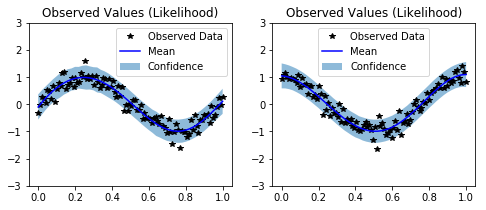

In [8]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
# Test points every 0.02 in [0,1]

# Make predictions
with torch.no_grad():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))
    # Get mean
    mean = observed_pred.mean()
    mean = mean.view(51, 2)
    # Get lower and upper confidence bounds
    lower, upper = observed_pred.confidence_region()
    lower = lower.view(51, 2)
    upper = upper.view(51, 2)
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Define plotting function
def ax_plot():

    # Plot training data as black stars
    y1_ax.plot(train_x.detach().numpy(), train_y1.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
    # Shade in confidence 
    y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
    y1_ax.set_ylim([-3, 3])
    y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y1_ax.set_title('Observed Values (Likelihood)')
    
    # Plot training data as black stars
    y2_ax.plot(train_x.detach().numpy(), train_y2.detach().numpy(), 'k*')
    # Predictive mean as blue line
    y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
    # Shade in confidence 
    y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
    y2_ax.set_ylim([-3, 3])
    y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
    y2_ax.set_title('Observed Values (Likelihood)')

# Plot both tasks
ax_plot()